<a href="https://colab.research.google.com/github/achmadbadri/Aktivasi-LSTM/blob/main/WEHA_Trans_Darat_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 8.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=fdbb5f4bfd28b5d9e6d5374baee246aecfa56b0fa7812d36763b3fe3594564c6
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import datetime
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import style
from google.colab import files
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline
#read yahoo data
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Code to Measure time taken by program to execute.
import time
# store starting time
begin = time.time()

In [ ]:
df = pdr.get_data_yahoo("WEHA.JK", start="2010-01-01", end="2019-02-28")
test_df = pdr.get_data_yahoo("WEHA.JK", start="2019-02-15", end="2020-03-01")
# Dataset is now stored in a Pandas Dataframe
print(df.shape)
print(test_df.shape)

print("end of read data ----------------------------------")
print("end of read data ----------------------------------")

# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 
print("-----------------------------")
print("-----------------------------")

# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

#Pemisah ------------------------

'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 10, 1))

#Pemisah ------------------------

# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 1000, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 1000, return_sequences = False))
model.add(Dropout(0.2))

# Output layer

model.add(Dense(units = 1, activation= 'tanh'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_percentage_error'])

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 10, batch_size = 20, validation_split=.30)

# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 10
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
true = y_test
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 10, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
pred = predicted_y
predicted_y = scaler.inverse_transform(predicted_y)

#Pemisah ------------------------

predicted_y = pd.DataFrame(predicted_y)
org_y = pd.DataFrame(org_y)
describe = pd.DataFrame()
describe['True Price'] = org_y[0]
describe['Prediction'] = predicted_y[0]
describe['difference'] = org_y[0] - predicted_y[0]
describe['MAPE (%)'] = abs(describe['difference']/org_y[0]*100)
describe.describe()

#Pemisah ------------------------

final  = test_df.drop(test_df.index[0:10])
final.reset_index(inplace=True)
final.rename(columns = {'index':'Date'})
final = final.drop(columns=['High','Low','Open','Volume','Close'])
final['Predict_Value'] = predicted_y[0]
final['Selisih'] = final['Adj Close'] - final['Predict_Value']
final['Lost/Risk (%)'] = abs((final['Adj Close'] - final['Predict_Value'])/final['Predict_Value']*100)
final = final.drop(columns=['Adj Close'])
percent = test_df.drop(test_df.index[0:9])
percent = percent.drop(test_df.index[-1])
percent.reset_index(inplace=True)
percent.rename(columns = {'index':'Date'}) 
percent = percent.drop(columns=['High','Low','Open','Volume','Close'])
percent['Next Day'] = predicted_y
percent['Plus or Minus']= percent['Adj Close'] - percent['Next Day']
percent['Next Day (%)']= (((percent['Adj Close'] - percent['Next Day'])/percent['Adj Close'])*100)
True_Next_Day = test_df.drop(test_df.index[0:9])
True_Next_Day = True_Next_Day.drop(test_df.index[-1])
True_Next_Day.reset_index(inplace=True)
True_Next_Day.rename(columns = {'index':'Date'}) 
True_Next_Day = True_Next_Day.drop(columns=['High','Low','Open','Volume','Close'])
True_Next_Day['True Next Day'] = org_y
True_Next_Day['True Plus or Minus']= (True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])
True_Next_Day['True Next Day (%)']= (((True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])/True_Next_Day['Adj Close'])*100)
True_Next_Day = True_Next_Day.drop(columns=['Adj Close'])
Concating = percent.merge(final, how='outer', on='Date')
Concating = Concating.merge(True_Next_Day, how='outer', on='Date')
#Concating.set_index('Date', inplace=True)
Final_Predict = Concating.copy()
Final_Predict['Harga Saham Hari ini'] = Concating['Adj Close']
Final_Predict['Prediksi Besok'] = Concating['Plus or Minus']
Final_Predict['Harga Besok Sebenarnya'] = Concating['True Plus or Minus']
Final_Predict['Prediksi Besok (%)'] = (Concating['Next Day (%)'])
Final_Predict['Harga Besok Sebenarnya (%)'] = Concating['True Next Day (%)']
Final_Predict['Selisih Prediksi'] = (Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])
Final_Predict['Harga Sebenarnya'] = Concating['True Next Day']
#Mape V1
Final_Predict['Risk/MAPE(%) - V1'] = (np.abs((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok']) / Final_Predict['Harga Sebenarnya'])) * 100
Final_Predict['Risk/MAPE(%) - V1'] = round(Final_Predict['Risk/MAPE(%) - V1'], 2)
#Mape V2
Final_Predict['Risk/MAPE(%)- V2'] = (np.abs((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok']) / Final_Predict['Harga Besok Sebenarnya'])) * 100
Final_Predict['Risk/MAPE(%)- V2'] = round(Final_Predict['Risk/MAPE(%)- V2'], 2)
Final_Predict = Final_Predict.drop(columns=['Adj Close', 'Next Day', 'Plus or Minus', 'Next Day (%)',
                                            'Predict_Value', 'Selisih', 'Lost/Risk (%)', 'True Plus or Minus',
                                            'True Next Day (%)','True Next Day'])
Final_Predict = Final_Predict.replace(0, np.nan)
Final_Predict = Final_Predict.dropna()
Final_Predict['Prediksi Uptrend'] = Final_Predict['Prediksi Besok'].apply(lambda x: 1 if x >= 0 else 0)
Final_Predict['Asli Uptrend'] = Final_Predict['Harga Besok Sebenarnya'].apply(lambda x: 1 if x >= 0 else 0)
Final_Predict.set_index('Date', inplace=True)
Final_Predict.shape
#Pemisah ------------------------
print("---------------------------------------------")
print("---------------------------------------------")

a = np.array(describe['True Price'])
b = np.array(describe['Prediction'])

# MSE
difference_array = np.subtract(a, b)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print("MSE :", mse)

# The RMSE
print("RMSE: %.2f" % mean_squared_error(a, b, squared=False))

# The MAE
print("MAE: %.2f" % mean_absolute_error(a, b))

#Mean Absolute Percentange Error
c = (np.mean(np.abs((a - b) / a))) * 100
print('MAPE : ', c)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(a, b))
print("---------------------------------------------")
print("---------------------------------------------")
pred_uptrend = Final_Predict['Prediksi Uptrend']
true_trend = Final_Predict['Asli Uptrend']

# calculate accuracy
from sklearn.metrics import accuracy_score
Accuracy = accuracy_score(true_trend, pred_uptrend)
print('Accuracy :', Accuracy)


# calculate prediction
from sklearn.metrics import precision_score
precision = precision_score(true_trend, pred_uptrend, average='binary')
print('Precision : %.3f' % precision)

# calculate recall
from sklearn.metrics import recall_score
recall = recall_score(true_trend, pred_uptrend, average='binary')
print('Recall : %.3f' % recall)

# calculate score
from sklearn.metrics import f1_score
score = f1_score(true_trend, pred_uptrend, average='binary')
print('F1 Score : %.3f' % score)

#AUC Score
from sklearn.metrics import roc_auc_score 
auc = roc_auc_score(true_trend, pred_uptrend)
print('AUC Score : ', auc)

print("---------------------------------------------")
print("---------------------------------------------")
#Pemisah ------------------------

# program body ends
  
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime of the program is {end - begin}")
print("---------------------------------------------")
print("---------------------------------------------")
#Pemisah ------------------------
model.save('/content/gdrive/MyDrive/WEHA-JOURNAL-tanh-code1')
print("---------------------------------------------")
print("end of session 1")
print("---------------------------------------------")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(2217, 6)
(261, 6)
end of read data ----------------------------------
end of read data ----------------------------------
(2217,)
-----------------------------
-----------------------------
Epoch 1/10
78/78 [==============================] - 59s 725ms/step - loss: 0.0065 - mean_absolute_percentage_error: 35019.8438 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 6.3397
Epoch 2/10
78/78 [==============================] - 56s 714ms/step - loss: 0.0012 - mean_absolute_percentage_error: 70067.9453 - val_loss: 6.2333e-04 - val_mean_absolute_percentage_error: 4.5666
Epoch 3/10
78/78 [==============================] - 55s 709ms/step - loss: 0.0011 - mean_absolute_percentage_error: 128816.6719 - val_loss: 9.8044e-04 - val_mean_absolute_percentage_error: 6.6242
Epoch 4/10
78/78 [==============================] - 55s 710ms/step - loss: 0.0017 - mean_

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WEHA-JOURNAL-tanh-code1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/WEHA-JOURNAL-tanh-code1/assets


---------------------------------------------
end of session 1
---------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

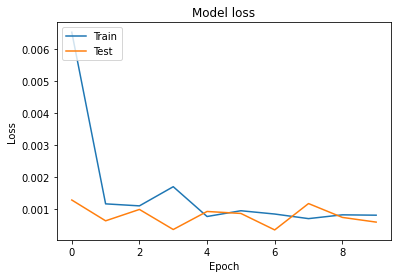

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss values WEHA JOUNAL CODE - 2019 - tanh- Code 2.png')
files.download("loss values WEHA JOUNAL CODE - 2019 - tanh- Code 2.png")
plt.show()

In [ ]:
graph  = test_df.drop(test_df.index[0:10])
graph.reset_index(inplace=True)
graph.rename(columns = {'index':'Date'})
graph = graph.drop(columns=['High','Low','Open','Volume','Close'])
graph['Predict_Value'] = predicted_y[0]
graph.head()
graph.set_index('Date', inplace=True)

In [ ]:
Final_Predict.to_csv('WEHA JOUNAL CODE - 2019 - tanh- Code 1.csv') 
files.download('WEHA JOUNAL CODE - 2019 - tanh- Code 1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

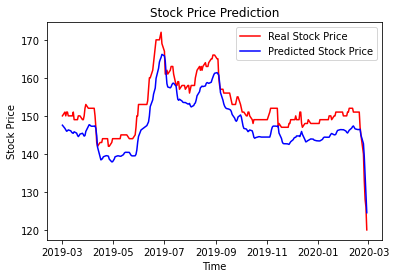

In [ ]:
# plot the results 
plt.plot(graph['Adj Close'], color = 'red', label = 'Real Stock Price')
plt.plot(graph['Predict_Value'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(df['Adj Close'], color = 'black', label = 'Past Stock')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Grafik I WEHA JOUNAL CODE - 2019 - tanh- Code 1.png')
files.download("Grafik I WEHA JOUNAL CODE - 2019 - tanh- Code 1.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

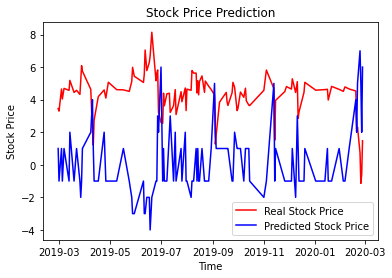

In [ ]:
# plot the results 
plt.plot(Final_Predict['Prediksi Besok'], color = 'red', label = 'Real Stock Price')
plt.plot(Final_Predict['Harga Besok Sebenarnya'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(Final_Predict['Risk/MAPE(%)'], color = 'black', label = 'RISK/MAPE(%)')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Grafik II WEHA JOUNAL CODE - 2019 - tanh- Code 1.png')
files.download("Grafik II WEHA JOUNAL CODE - 2019 - tanh- Code 1.png")
plt.show()